In [ ]:
import csv
import os
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle
import random
import dask.dataframe as dd
from collections import defaultdict
from dataclasses import dataclass
from zipfile import ZipFile
import pandas as pd
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.model_selection import KFold, train_test_split
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print('Max cpu detected: {}'.format(multiprocessing.cpu_count()))
#npartitions = multiprocessing.cpu_count()

Max cpu detected: 2


In [ ]:
if tf.config.list_physical_devices('GPU'):
    print('GPU available ;)')
else:
    print('No GPU detected...when it comes to training please set the accelerator to use a GPU')

No GPU detected...when it comes to training please set the accelerator to use a GPU


In [ ]:
data_path = '/content/drive/MyDrive/Internship/labeled_training_data.csv'

@dataclass
class CONFIG():
  """
  """
  embedding_dim = 300
  maxlen = 50
  vocab_size = 200000
  truncating = 'post'
  padding = 'post'
  oov_token = '<OOV>'
  max_examples = 160000
  training_split = .9

Config = CONFIG()

data = pd.read_csv(data_path,
                   encoding = "ISO-8859-1")

print('Dataset size {}'.format(len(data)))
print('Dataset first five rows:\n{}'.format(data.head()))

ParserError: Error tokenizing data. C error: Expected 1 fields in line 47, saw 2


NameError: name 'data' is not defined

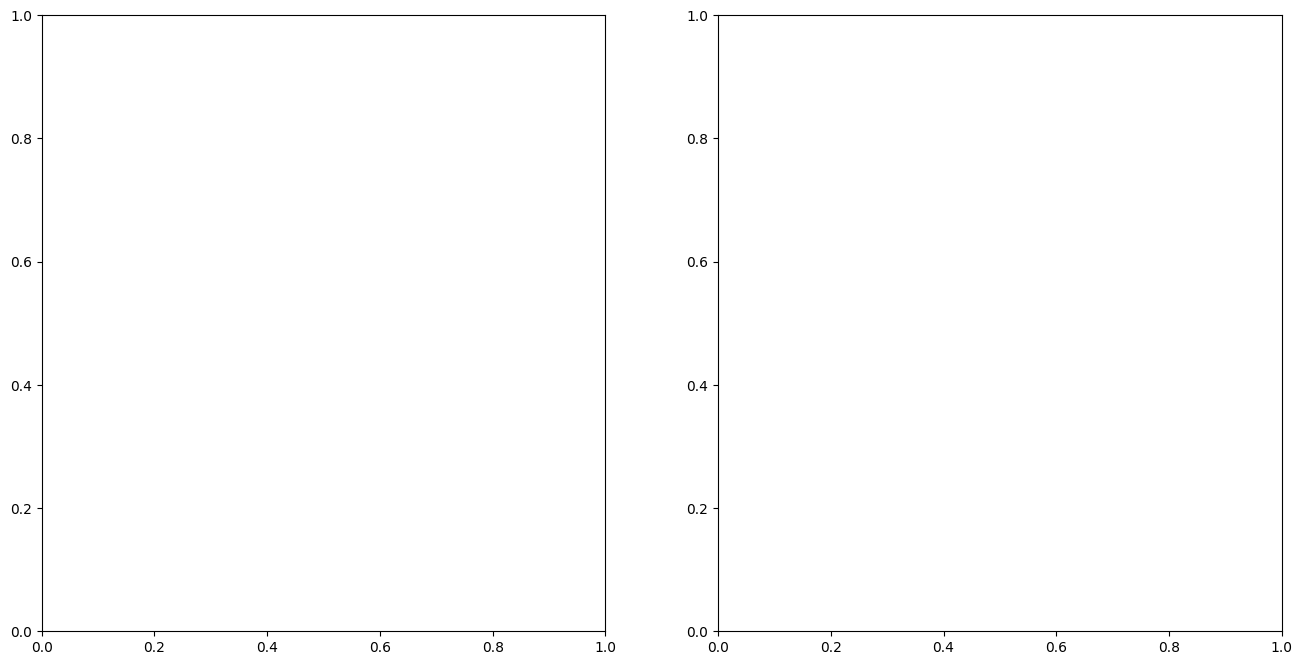

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,
                               figsize = (16, 8))

data.target.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Before remapping')
data.target = data.target.map({0 : 0,
                               4 : 1})
data.target.value_counts().plot(kind = 'bar', ax = ax2)
ax2.set_title('After remapping')
plt.tight_layout()

In [ ]:
# Sample text to check appearance of special characters
stop_words = stopwords.words('english')
porter = nltk.stem.PorterStemmer()
remove_links = "https?:\S+|http?:\S|[0-9]+"
rep_elipse = "\.{2,}"
stop_list = stop_words + list(string.punctuation)

In [ ]:
def preprocess_tweet(tweet: str,
                     stemmer: object,
                     remove_links_regex,
                     reduce_elipses_regex):
  """
  """
  tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,
                                                 reduce_len=True)
  # remove links and numbers

  tweet = re.sub(remove_links_regex, '', str(tweet))
  # Tokenize
  tweet = tweet_tokenizer.tokenize(tweet)
  # Remove stop words
  tweet = [stemmer.stem(token.lower().strip()) for token in tweet if token not in stop_list]
  tweet =  ' '.join(tweet)

  # Replace elipse (two or more .. with ..)
  tweet = re.sub(reduce_elipses_regex, '..', str(tweet))

  return tweet

In [ ]:
test = data.head()
test = test['text'].apply(lambda x: preprocess_tweet(x, porter, remove_links, rep_elipse))
print('Before: {}'. format(list(data['text'][:5])))
print('After: {}'. format(list(test[:5])))

Before: ["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "]
After: ["awww that' bummer you shoulda got david carr third day ;d", "upset can't updat facebook text .. might cri result school today also blah", 'i dive mani time ball manag save the rest go bound', 'whole bodi feel itchi like fire', "behav i'm mad i can't see"]


In [ ]:
def preprocess_tweet_df(dd:object):
  """
  """
  dd['text'] = data['text'].map(lambda tweet: preprocess_tweet(tweet,
                                                               porter,
                                                               remove_links,
                                                               rep_elipse))

  return dd

In [ ]:
print('Some stop word examples ... {}'.format(list(stop_words[:10])))

Some stop word examples ... ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [ ]:
X, y  = data['text'].tolist(), data.pop('target').to_numpy()

In [ ]:
X = [preprocess_tweet(tweet,porter,remove_links,rep_elipse) for tweet in X]

In [ ]:
processed = [(X[i], y[i]) for i, tweet in enumerate(X)]

In [ ]:
print('Post preprocessing check: {}'.format(list(X[:5])))

Post preprocessing check: ["awww that' bummer you shoulda got david carr third day ;d", "upset can't updat facebook text .. might cri result school today also blah", 'i dive mani time ball manag save the rest go bound', 'whole bodi feel itchi like fire', "behav i'm mad i can't see"]


In [ ]:
with open('/content/drive/MyDrive/Internship/labeled_training_data.csv', 'wb') as f:
  pickle.dump(processed, f)

In [ ]:
# Load processed tweets with target data
with open('/content/drive/MyDrive/Internship/labeled_training_data.csv', 'rb') as f:
  processed = pickle.load(f)

print('Processed data: {}'.format(processed[0]))

X, y = zip(*processed)

Processed data: ("awww that' bummer you shoulda got david carr third day ;d", 0)


In [ ]:
print(len(X))
print(len(y))

1599999
1599999


In [ ]:
# Split in training validation and test sets
X_train, X_test, y_train, y_test = test = train_test_split(X, y,
                                                           shuffle = True,
                                                           random_state=1,
                                                           test_size = 10000,
                                                           stratify = y)

print('Train/val size is {}'.format(len(X_train)))
print('Test size is {}'.format(len(X_test)))
print('Example train/val tweet: {}'.format(X_train[:1]))
print('Example test tweet: {}'.format(X_test[:1]))

Train/val size is 1589999
Test size is 10000
Example train/val tweet: ['lol stop bin actual upgrad dine tabl actual desk']
Example test tweet: ["my soul longer desir twitter natali tim can't see phone"]


In [ ]:
def fit_tokenizer(train_sentences, oov_token, vocab_size):
  """
  """

  tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)

  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

In [ ]:
tokenizer = fit_tokenizer(X, oov_token = Config.oov_token, vocab_size = Config.vocab_size)

word_index = tokenizer.word_index

print('Vocab contains {} words'.format(Config.vocab_size))
print('<OOV> token successfully placed in vocabulary!' if '<OOV>' in word_index else 'No <OOV> in vocabulary! something went wrong :(')

Vocab contains 200000 words
<OOV> token successfully placed in vocabulary!


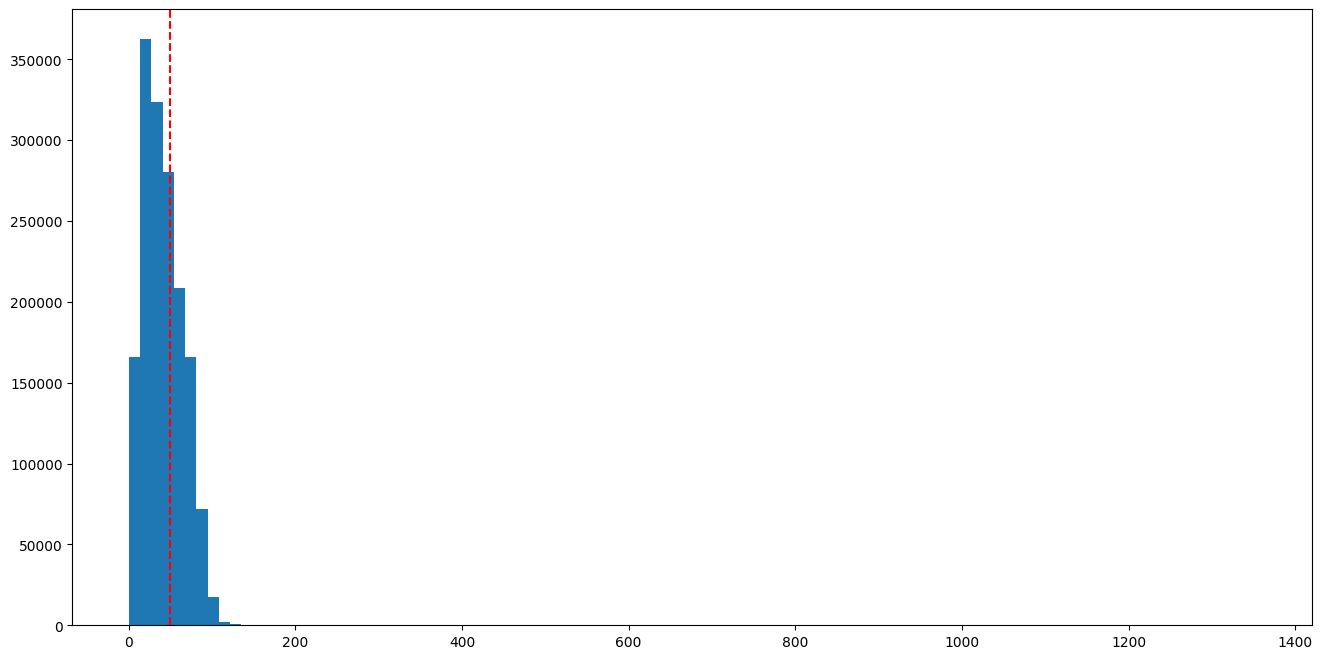

In [ ]:
tweet_lengths = [len(tweet) for tweet in X]
plt.figure(figsize=(16,8))
plt.hist(tweet_lengths,
         bins = 100)
plt.axvline( Config.maxlen,
            ls = '--',
            c = 'red')
plt.show()

In [ ]:
def tokenise_sentences(tweets: list,
                       tokenizer: object,
                       padding: str,
                       truncating: str,
                       maxlen: int):
  """
  """

  tweets = tokenizer.texts_to_sequences(tweets)

  padded_and_trunc_tweets = pad_sequences(sequences = tweets,
                                          maxlen = maxlen,
                                          truncating = truncating,
                                          padding = padding)

  return padded_and_trunc_tweets

# Try increasing the maxlen ;)

In [ ]:
X_train = tokenise_sentences(X_train, tokenizer, Config.padding, Config.truncating, Config.maxlen)
X_test = tokenise_sentences(X_test, tokenizer, Config.padding, Config.truncating, Config.maxlen)

In [ ]:
print('Tokenised tweets have shape {}'.format(X_train.shape))

Tokenised tweets have shape (1589999, 50)


In [ ]:
def sentiment_classifier_embedding_max(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.GlobalMaxPooling1D(),
                               tf.keras.layers.Dropout(.3),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ['acc'])

  return model

In [ ]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(0.001),
                metrics = ['acc'])

  return model

In [ ]:
sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

In [ ]:
# Instantiate model checkpoint callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=1,verbose=0,mode='auto')

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
kf = KFold(n_splits=3,
           shuffle=True,
           random_state=1)

fold = 0

# takes a while to train ...
epochs = 3

model_eval = defaultdict(list)
# 10 fold cross validation strategy
for train_index, test_index in kf.split(X_train):
    cv_X_train, cv_X_val= X_train[train_index], X_train[test_index]
    cv_y_train, cv_y_val = y_train[train_index], y_train[test_index]
    print('Fold: {}'.format(fold))
    print('# train: {}\n# val: {}'.format(len(train_index), len(test_index)))

    # reinitialise classifers to reset weights
    '''sentiment_classifier_max_model = sentiment_classifier_embedding_max(Config.vocab_size, Config.embedding_dim, Config.maxlen)'''
    sentiment_classifier_lstm_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)

    # train model 1
    '''history_max = sentiment_classifier_max_model.fit(cv_X_train,
                                             cv_y_train,
                                             validation_data = (cv_X_val, cv_y_val),
                                             callbacks = [early_stopping, reduce_lr],
                                             epochs = epochs,
                                             batch_size = 128)'''
    # train model 2
    history_lstm = sentiment_classifier_lstm_model.fit(cv_X_train,
                                               cv_y_train,
                                               validation_data = (cv_X_val, cv_y_val),
                                               callbacks = [early_stopping, reduce_lr],
                                               epochs = epochs,
                                               batch_size = 128)


    # make predictions on hold out validation set for each model
    '''_ , acc = sentiment_classifier_max_model.evaluate(cv_X_val, cv_y_val)'''
    _ , acc2 = sentiment_classifier_lstm_model.evaluate(cv_X_val, cv_y_val)

    # calculate performance metric
    '''model_eval['sentiment_classifier_embedding_max'].append(acc)'''
    model_eval['sentiment_classifier_embedding_lstm'].append(acc2)

    fold += 1


'''performance1 = np.mean(model_eval['sentiment_classifier_embedding_max']) - np.std(model_eval['sentiment_classifier_embedding_max'])'''
performance2 = np.mean(model_eval['sentiment_classifier_embedding_lstm']) - np.std(model_eval['sentiment_classifier_embedding_lstm'])

Fold: 0
# train: 1059999
# val: 530000
Epoch 1/3
8282/8282 [==============================] - 184s 22ms/step - loss: 0.4613 - acc: 0.7785 - val_loss: 0.4443 - val_acc: 0.7890 - lr: 0.0010
Epoch 2/3
8282/8282 [==============================] - 147s 18ms/step - loss: 0.4252 - acc: 0.8014 - val_loss: 0.4372 - val_acc: 0.7941 - lr: 0.0010
Epoch 3/3
8282/8282 [==============================] - 149s 18ms/step - loss: 0.4040 - acc: 0.8133 - val_loss: 0.4368 - val_acc: 0.7946 - lr: 0.0010
Epoch 1/3
8282/8282 [==============================] - 242s 29ms/step - loss: 0.4564 - acc: 0.7839 - val_loss: 0.4472 - val_acc: 0.7968 - lr: 0.0010
Epoch 2/3
8282/8282 [==============================] - 214s 26ms/step - loss: 0.4014 - acc: 0.8159 - val_loss: 0.4442 - val_acc: 0.7965 - lr: 0.0010
Epoch 3/3
16563/16563 [==============================] - 75s 5ms/step - loss: 0.4445 - acc: 0.7936
Fold: 1
# train: 1059999
# val: 530000
Epoch 1/3
8282/8282 [==============================] - 173s 21ms/step - loss: 

In [ ]:
print('Performance of Embedding max model: {}'.format(performance1))
print('Performance of LSTM model: {}'.format(performance2))

Performance of Embedding max model: 0.7939029736949055
Performance of LSTM model: 0.7940380198050428


In [ ]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid)
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['acc'])

  return model

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 5))

tune_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen)
# Since the dataset is large ... lets reduce the dataset size
history = tune_model.fit(cv_X_train[:100000],
                         cv_y_train[:100000],
                         validation_data = (cv_X_val[:100000], cv_y_val[:100000]),
                         callbacks = [lr_schedule],
                         epochs = 30,
                         batch_size = 128)

Epoch 1/30
782/782 [==============================] - 41s 45ms/step - loss: 0.6929 - acc: 0.5066 - val_loss: 0.6927 - val_acc: 0.5108 - lr: 1.0000e-06
Epoch 2/30
782/782 [==============================] - 23s 29ms/step - loss: 0.6927 - acc: 0.5118 - val_loss: 0.6922 - val_acc: 0.5351 - lr: 1.5849e-06
Epoch 3/30
782/782 [==============================] - 22s 28ms/step - loss: 0.6922 - acc: 0.5218 - val_loss: 0.6914 - val_acc: 0.5578 - lr: 2.5119e-06
Epoch 4/30
782/782 [==============================] - 21s 27ms/step - loss: 0.6915 - acc: 0.5339 - val_loss: 0.6896 - val_acc: 0.5836 - lr: 3.9811e-06
Epoch 5/30
782/782 [==============================] - 22s 28ms/step - loss: 0.6892 - acc: 0.5566 - val_loss: 0.6853 - val_acc: 0.6083 - lr: 6.3096e-06
Epoch 6/30
782/782 [==============================] - 21s 26ms/step - loss: 0.6818 - acc: 0.5962 - val_loss: 0.6692 - val_acc: 0.6451 - lr: 1.0000e-05
Epoch 7/30
782/782 [==============================] - 24s 30ms/step - loss: 0.6421 - acc: 0.66

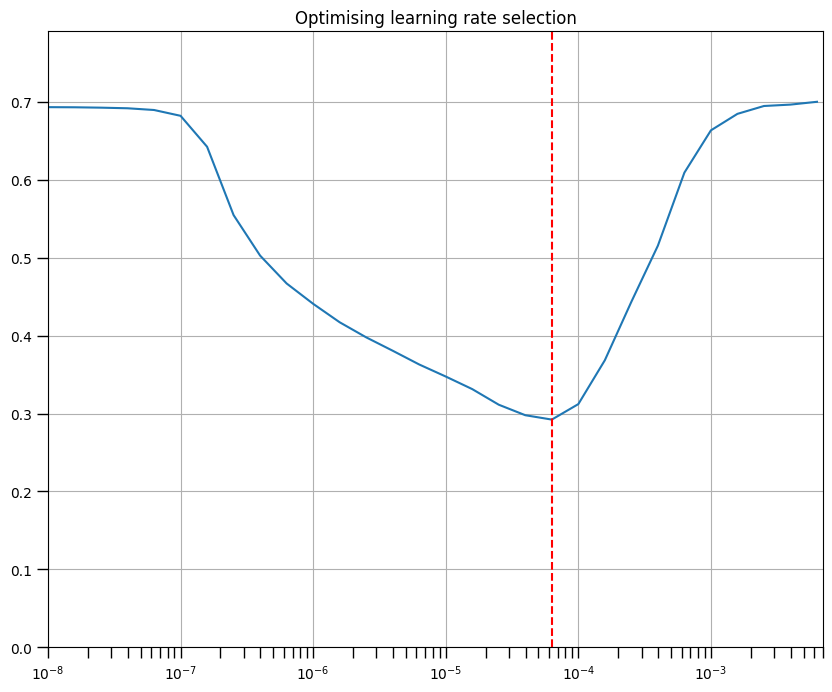

In [ ]:
learning_rates = 1e-8 * (10 ** ((np.arange(30))/5))
best_lr = learning_rates[np.argmin(history.history['loss'])]
#without removing this colab will die
tune_model=[]
plt.figure(figsize = (10,8))
plt.grid(True)
plt.semilogx(learning_rates, history.history["loss"])
plt.tick_params('both', length=8, width=1, which = 'both')
plt.axis([1e-8,.007,0,.79])

plt.axvline(learning_rates[np.argmin(history.history['loss'])],
            ls = '--',
            c = 'red')
plt.title('Optimising learning rate selection')
plt.show()

In [ ]:
def sentiment_classifier_lstm(vocab_size, embedding_dim, maxlen, best_lr):
  """
  """
  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = maxlen),
                               tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, name = 'lstm_layer')),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(32, activation = tf.nn.relu, name = 'dense_layer_1'),
                               tf.keras.layers.Dropout(.4),
                               tf.keras.layers.Dense(16, activation = tf.nn.relu,name = 'dense_layer_2'),
                               tf.keras.layers.Dense(1, activation = tf.nn.sigmoid,name = 'output_layer')
  ])

  model.compile(loss = 'binary_crossentropy',
                optimizer = tf.keras.optimizers.Adam(best_lr),
                metrics = ['acc'])

  return model

In [ ]:
final_model = sentiment_classifier_lstm(Config.vocab_size, Config.embedding_dim, Config.maxlen, best_lr)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=0,mode='auto')

# The below will only save if the val accuracy improves. This means we can later load the best model without worrying about overtraining.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Internship/labeled_training_data.csv_{epoch:02d}_{acc:.2f}',
                                                               save_weights_only=False,
                                                               monitor='val_acc',
                                                               mode='max',
                                                               save_best_only=True)
history = final_model.fit(X_train[:-5000],
                         y_train[:-5000],
                         validation_data = (X_train[-5000:], y_train[-5000:]),
                         callbacks = [reduce_lr,model_checkpoint_callback],
                         epochs = 10,
                         batch_size = 128)

NameError: name 'sentiment_classifier_lstm' is not defined

In [11]:
final_model = tf.saved_model.load('/content/drive/MyDrive/Internship/labeled_training_data.csv_05_0.82/')

In [ ]:
final_model.evaluate(X_test, y_test)

In [ ]:
#pickle
#tensorflow
#HDF5
#model.predict